In [308]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings


from scipy.stats import binom, poisson
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

In [309]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def bilions_formatter(x, pos):
    return f'{x / 1e9} B'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### **1. Load and import datasets**

In [310]:
migration_df = pd.read_csv('PEA18.20231016T141007.csv')

In [311]:
#Cleaned datasets
population_df_1996 = pd.read_csv('population_df_1996.csv')
migration_df_1996 = pd.read_csv('migration_df_1996.csv')

Creating age groups to see population distribution by age

In [312]:
population_age_breakdown_df = population_df_1996[(population_df_1996['Single Year of Age'] != 'All ages') & (population_df_1996['Year'] > 2012) & (population_df_1996['Sex'] == 'Both sexes')]
population_age_breakdown_df = population_age_breakdown_df.drop(['Sex category', 'Sex'], axis=1)


In [313]:
try:
    population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].replace('Under 1 year', '0 year')
    output = population_age_breakdown_df.head()
except Exception as e:
    output = f"An error occurred: {e}"

output

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0 year,Number,68583
5157,2013,001,1 year,Number,71785
5160,2013,002,2 years,Number,70638
5163,2013,003,3 years,Number,71057
5166,2013,004,4 years,Number,70956


Using 'try' and 'except' for handling errors that can occur during the execution of a program, as I experienced some errors when replacing the value.

In [314]:
population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].str.extract(r'(\d+)').astype(int)
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0,Number,68583
5157,2013,001,1,Number,71785
5160,2013,002,2,Number,70638
5163,2013,003,3,Number,71057
5166,2013,004,4,Number,70956
...,...,...,...,...,...
8469,2023,095,95,Number,2128
8472,2023,096,96,Number,1581
8475,2023,097,97,Number,1116
8478,2023,098,98,Number,829


Using regex in order to extract only the integer values from the 'Single Year of Age' category, from which I will later on create Age groups. 

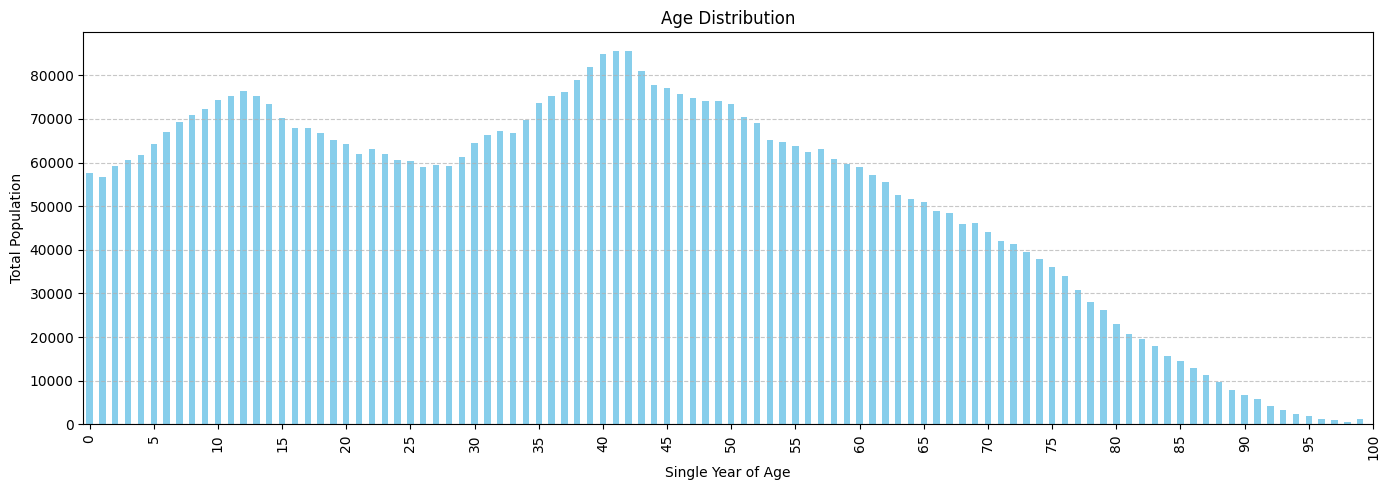

In [315]:
population_age_distribution_2022 = population_age_breakdown_df[population_age_breakdown_df['Year'] == 2022]

population_age_distribution = population_age_distribution_2022.groupby("Single Year of Age")["VALUE"].sum()

plt.figure(figsize=(14, 5))
population_age_distribution.plot(kind='bar', color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 101, 5), range(0, 101, 5), rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [316]:
population_age_distribution_2022.tail()

,Year,Age category,Single Year of Age,UNIT,VALUE
8166,2022,095,95,Number,1821
8169,2022,096,96,Number,1282
8172,2022,097,97,Number,949
8175,2022,098,98,Number,621
8178,2022,646,99,Number,1185


The bar chart visualizes the distribution of population across different ages for the given year (2022). 

There seems to be a higher number of individuals in the younger age categories. The bars are taller at the left side of the chart, indicating larger populations in younger age groups. The  same is true for the ages between 36 and 45. As the age increases, there is a general trend of decreasing population numbers. 

In [317]:
weighted_mean = np.average(population_age_distribution_2022["Single Year of Age"], weights=population_age_distribution_2022["VALUE"])

weighted_variance = np.average((population_age_distribution_2022["Single Year of Age"] - weighted_mean)**2, weights=population_age_distribution_2022["VALUE"])
weighted_std = np.sqrt(weighted_variance)

sorted_df = population_age_distribution_2022.sort_values(by="Single Year of Age")
cumsum = sorted_df["VALUE"].cumsum()
cutoff = cumsum.iloc[-1] / 2.0
weighted_median = sorted_df[sorted_df["VALUE"].cumsum() >= cutoff]["Single Year of Age"].iloc[0]

print(f"Variance: {weighted_variance}")
print(f"Mean: {weighted_mean:.8f}")
print(f"Median: {weighted_median:.8f}")
print(f"Std: {weighted_std:.8f}")

Variance: 520.713923652503
Mean: 38.37414636
Median: 38.00000000
Std: 22.81915694


I had to use the weighted mean as per the structure of the data. Since for each Year we have each Single Year of Age once, using the mean function will only give us the mean value for the values from 0 to 99 years (as those are all the Single Years of age within the data), which will be 49.5, which is not correct. An example of calculating it like that can be seen below.

In [318]:
avg_for_example = population_age_distribution_2022['Single Year of Age'].mean()
avg_for_example

49.5

From the above calculations we can see that the average age in Ireland for 2022 was 38.4 years. Compared with the official CSO data here - https://www.cso.ie/en/csolatestnews/pressreleases/2023pressreleases/pressstatementcensusofpopulation2022-summaryresults/#:~:text=The%20average%20age%20of%20the,a%2063%25%20increase%20from%202016. we can observe a difference of only 0.4 for the average value for 2022. 

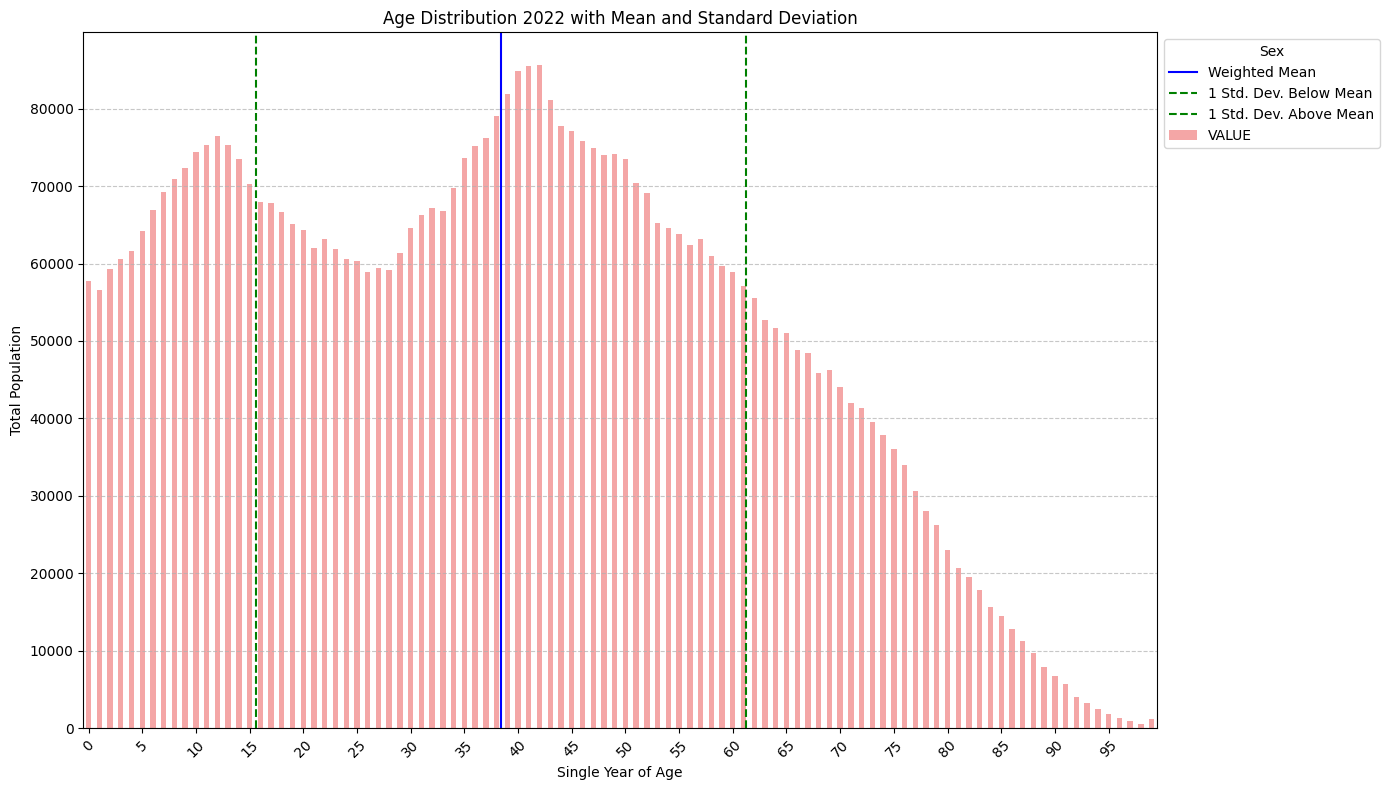

In [319]:
plt.figure(figsize=(14, 8))
population_age_distribution.plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title("Age Distribution 2022 with Mean and Standard Deviation")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 100, 5), range(0, 100, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.axvline(x=weighted_mean, color='blue', linestyle='-', label='Weighted Mean')
plt.axvline(x=weighted_mean - weighted_std, color='green', linestyle='--', label='1 Std. Dev. Below Mean')
plt.axvline(x=weighted_mean + weighted_std, color='green', linestyle='--', label='1 Std. Dev. Above Mean')

plt.legend(title='Sex', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [320]:
def age_group(age):
    if age <= 14:
        return '0-14 years old'
    elif age <= 24:
        return '15-24 years old'
    elif age <= 44:
        return '25-44 years old'
    elif age <= 64:
        return '45-64 years old'
    else:
        return '65 and over'

population_age_breakdown_df['Age Group'] = population_age_breakdown_df['Single Year of Age'].apply(age_group)

population_age_breakdown_df


,Year,Age category,Single Year of Age,UNIT,VALUE,Age Group
5154,2013,200,0,Number,68583,0-14 years old
5157,2013,001,1,Number,71785,0-14 years old
5160,2013,002,2,Number,70638,0-14 years old
5163,2013,003,3,Number,71057,0-14 years old
5166,2013,004,4,Number,70956,0-14 years old
...,...,...,...,...,...,...
8469,2023,095,95,Number,2128,65 and over
8472,2023,096,96,Number,1581,65 and over
8475,2023,097,97,Number,1116,65 and over
8478,2023,098,98,Number,829,65 and over


Creating a pivot table so that we can see the value for each group age per each year. Aggregation function set up to sum as we want to sum all the values for each separate age group.

In [321]:
population_pivot_age_groups = population_age_breakdown_df.pivot_table(index='Year', columns='Age Group', values='VALUE', aggfunc='sum')

population_pivot_age_groups = population_pivot_age_groups.reset_index()
population_pivot_age_groups.columns.name = None
population_pivot_age_groups

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,993909,563278,1421081,1067215,569186
1,2014,997516,567222,1407323,1083895,589484
2,2015,1001705,571610,1400611,1103591,610270
3,2016,1005484,574697,1401520,1128049,629847
4,2017,1010356,587014,1403256,1157861,652408
5,2018,1014430,609252,1402768,1182019,676427
6,2019,1015539,623805,1406012,1211743,701372
7,2020,1013651,637923,1412015,1240171,726115
8,2021,1007602,640355,1411903,1267359,747449
9,2022,1014292,649717,1434196,1304462,781299


#### Binomial distribution

The binomial distribution is a way to figure out how likely it is to get a certain number of successes in a series of yes-or-no questions, where each question has the same chance of a yes.

In [322]:
binom_pop_dataset = population_pivot_age_groups[population_pivot_age_groups['Year'] == 2022]
binom_pop_dataset

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
9,2022,1014292,649717,1434196,1304462,781299


In [323]:
probability_0_14= binom_pop_dataset['0-14 years old'].values[0] / 5185988

probability_0_14

0.1955831752792332

In [324]:
n = 100 # Number of trials 
k = 20 # Number of successes we're interested in (people from the 0-14 age group
p = probability_0_14  # The probability of selecting someone from the 0-14 age group

probability = binom.pmf(k, n, p)
print(probability)

0.0986899218478517


Using the binomial distribution, the function provides the probability of getting exactly 20 successes (people from the 0-14 age group) when conducting 100 trials (selecting 100 people). The probability of selecting exactly 20 people from the "0-14 years old" age group when randomly choosing 100 people from the entire population is approximately 9.87%.

https://homepage.divms.uiowa.edu/~mbognar/applets/bin.html -- binomial distribution calculator

![binomial distribution](imgs/binom_calc.png)


As another example, I am interested in the probability of finding exactly 30 people from the '45-64 years old' age group when selecting 150 people at random. 


In [325]:
n_trials_new = 150    # Number of trials (selecting 150 people)
p_success_new = 1304462 / 5183966  # The probability of selecting someone from the 45-64 age group. 
#Those values are taken directly form the binom_pop_test table - number of people in the age group 45-64, and the total population for the year
k_successes_new = 30  # Number of successes we're interested in (people from the 45-64 age group)


binomial_probability_new = binom.pmf(k_successes_new, n_trials_new, p_success_new)
binomial_probability_new

0.026583077970737085

![binomial distribution2](imgs/binom2_calc.png)

The probability of selecting exactly 30 people from the "45-64 years old" age group when randomly choosing 150 people from the entire population is approximately 2.66%.

**Poisson distribution**

In my analysis, I will apply the Poisson distribution to model the number of immigration events, using historical data to determine lambda (λ), the average rate of immigration events per year.

To estimate the probability that the number of immigration events in a given year is less than the average number of emigration events, I use the cumulative distribution function (CDF) of the Poisson distribution. The CDF gives us the probability that the number of immigration events will be less than or equal to the average emigration level.

In [326]:
migration_df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
0,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,-13.7
1,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,21.8
2,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,8.1
3,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),1,Male,1,Net migration,Thousand,-9.0
4,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),1,Male,4,Emigrants: All destinations,Thousand,13.1


In [327]:
migration_df_for_poisson = migration_df[(migration_df['Sex'] == 'Both sexes') & (migration_df['Country'] == 'All countries')]


In [328]:
migration_df_for_poisson.to_csv('poisson_testttt.csv')

Getting the immigration and emigration, without any country or sex breakdown.

In [329]:
new_immigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Immigrants: All origins']['VALUE']
new_emigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Emigrants: All destinations']['VALUE']

new_mu_immigrants = new_immigrants.mean()
new_mu_emigrants = new_emigrants.mean()

# Calculate the probability that immigration is less than the mean emigration for the dataset
new_probability_less_than_emigration = poisson.cdf(new_mu_emigrants, new_mu_immigrants)

new_mu_immigrants, new_mu_emigrants, new_probability_less_than_emigration


(65.4054054054054, 48.45945945945945, 0.014999878372018471)

![binomial distribution2](imgs/poisson_distr.png)

As I am comparing the the probability of immigration being less than the mean emigration level, which is approximateley 48, we type in 48 for X. for λ (Lambda) I need the average rate of success (mean number of immigrants per year) being approximateley 65.

The probability that the number of immigration events in a year is less than the mean emigration level, is approximately 0.015. This suggests that, according to the Poisson model, there is a very low chance, and more specifically 1.5%, that immigration will be less than the average emigration.

Growth Rate=(Current Year Population - Previous Year Population / Previous Year Population)×100

In [330]:
growth_rates_df = population_pivot_age_groups.set_index('Year').pct_change() * 100

growth_rates_df = growth_rates_df.reset_index()
growth_rates_df

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,NaN,NaN,NaN,NaN,NaN
1,2014,0.362910,0.700187,-0.968136,1.562947,3.566145
2,2015,0.419943,0.773595,-0.476934,1.817150,3.526135
3,2016,0.377257,0.540054,0.064900,2.216220,3.207924
4,2017,0.484543,2.143216,0.123866,2.642793,3.581981
5,2018,0.403224,3.788325,-0.034776,2.086434,3.681592
6,2019,0.109322,2.388667,0.231257,2.514680,3.687759
7,2020,-0.185911,2.263207,0.426952,2.346042,3.527800
8,2021,-0.596754,0.381237,-0.007932,2.192278,2.938102
9,2022,0.663953,1.462002,1.578933,2.927584,4.528737


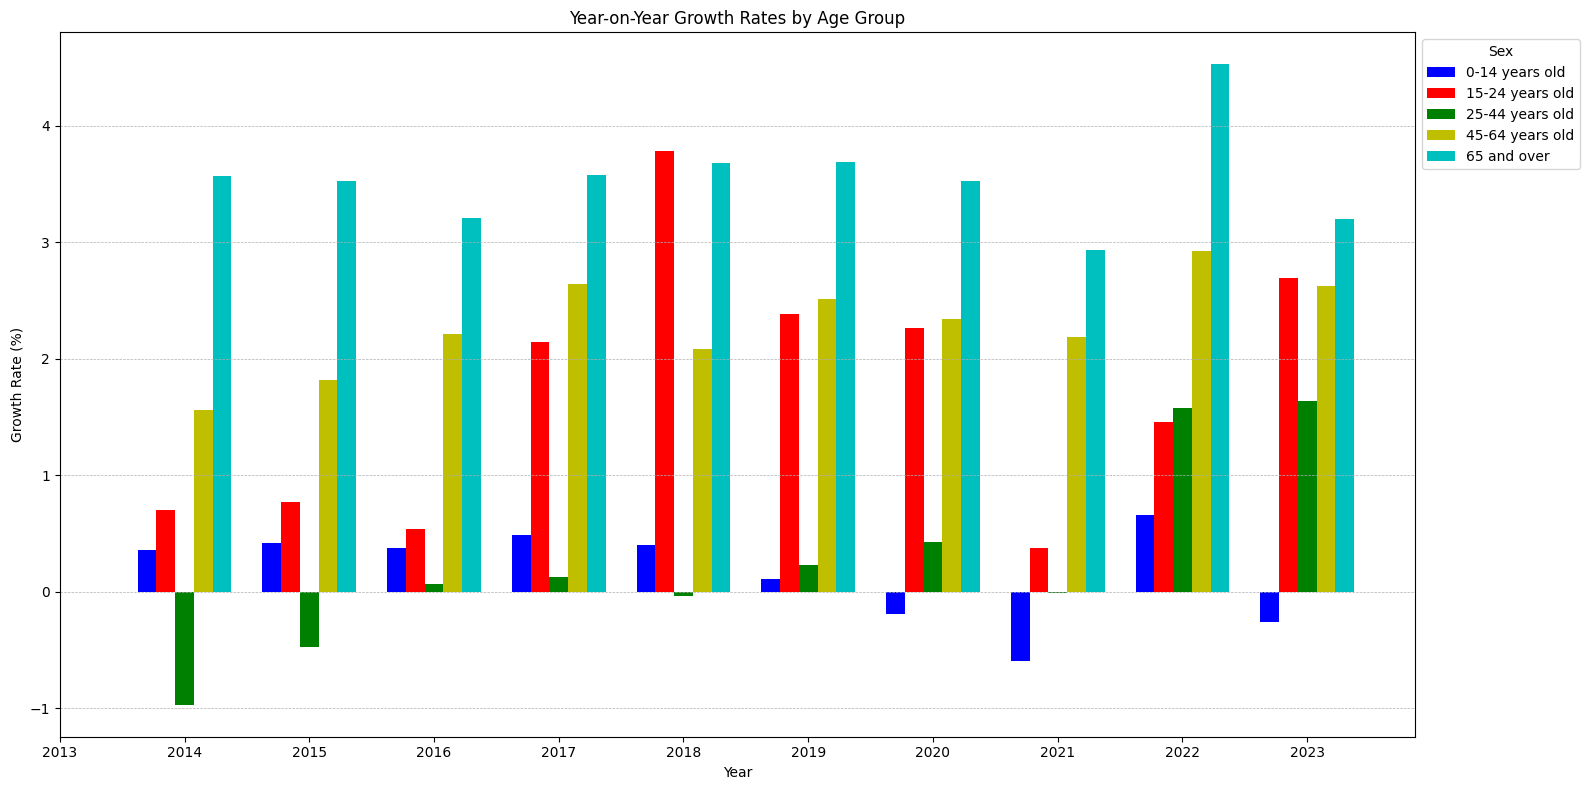

In [331]:
bar_width = 0.15
years = growth_rates_df['Year']
index = range(len(years))
colors = ['b', 'r', 'g', 'y', 'c']

plt.figure(figsize=(16, 8))

for idx, column in enumerate(growth_rates_df.columns[1:]):
    plt.bar(
        [i + idx * bar_width for i in index],
        growth_rates_df[column],
        width=bar_width,
        label=column,
        color=colors[idx]
    )

plt.title('Year-on-Year Growth Rates by Age Group')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks([i + 2 * bar_width for i in index], years)
plt.legend(title='Sex', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

 The "65 and over" category generally has higher growth rates, indicating a faster-growing elderly population compared to other age groups.

 The "0-14 years old" category shows fluctuations in growth rate, with some years showing negative growth.

 The "65 and over" category has a significant spike in 2022, which is the highest among all categories and years, suggesting a recent increase in the aging population or an anomaly in the data.

In [332]:
population_pivot_age_groups['Total Population'] = population_pivot_age_groups.sum(axis=1)

population_pivot_age_groups['Total Growth Rate'] = population_pivot_age_groups['Total Population'].pct_change() * 100

population_pivot_age_groups[['Year', 'Total Population', 'Total Growth Rate']]


,Year,Total Population,Total Growth Rate
0,2013,4616682,NaN
1,2014,4647454,0.666539
2,2015,4689802,0.911209
3,2016,4741613,1.104759
4,2017,4812912,1.503687
5,2018,4886914,1.537572
6,2019,4960490,1.505572
7,2020,5031895,1.439475
8,2021,5076689,0.890201
9,2022,5185988,2.152958


In [333]:
max_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmax(), 'Year']
min_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmin(), 'Year']
highest_growth_rate = population_pivot_age_groups['Total Growth Rate'].max()
lowest_growth_rate = population_pivot_age_groups['Total Growth Rate'].min()

dominant_age_groups = growth_rates_df.drop(columns='Year').idxmax(axis=1)

aligned_growth_rates_df, aligned_total_growth = growth_rates_df.set_index('Year').align(
    population_pivot_age_groups.set_index('Year')['Total Growth Rate'], axis=1)

age_groups_above_total = (aligned_growth_rates_df > aligned_total_growth).sum()
age_groups_below_total = (aligned_growth_rates_df < aligned_total_growth).sum()

growth_rate_std = growth_rates_df.drop(columns='Year').std()

print(f"Year with maximum growth: {max_growth_year} with a growth rate of: {highest_growth_rate:.6f}")
print(f"Year with minimum growth: {min_growth_year} with a growth rate of: {lowest_growth_rate:.6f}\n")

print("Dominant age groups by year:")
for year, age_group in dominant_age_groups.items():
    print(f"  {year}: {age_group}")

Year with maximum growth: 2022 with a growth rate of: 2.152958
Year with minimum growth: 2014 with a growth rate of: 0.666539

Dominant age groups by year:
  0: nan
  1: 65 and over
  2: 65 and over
  3: 65 and over
  4: 65 and over
  5: 15-24 years old
  6: 65 and over
  7: 65 and over
  8: 65 and over
  9: 65 and over
  10: 65 and over


We can see that for all the years in the dataset, except of the year 2018, the age group 65 and over had the highest growth rate. In 2018, the 15-24 years old had the highest growth rate. 

In [334]:
print("Standard deviation of the growth rate across age groups:")
for age_group, std_value in growth_rate_std.items():
    print(f"  {age_group}: {std_value:.6f}")

Standard deviation of the growth rate across age groups:
  0-14 years old: 0.400539
  15-24 years old: 1.122137
  25-44 years old: 0.812438
  45-64 years old: 0.409218
  65 and over: 0.423033


**Overall Population Growth:**

The year with the highest overall growth rate was 2022, with a growth rate of approximately 
2.15
%
The year with the lowest overall growth rate was 2014, with a growth rate of approximately 
0.67
%
Age Group Dominance:

The "65 and over" age group had the highest growth rate in most of the years. This suggests that the elderly population has been growing at a faster rate than other age groups in many years.


In [335]:
total_growth_trend = population_pivot_age_groups['Total Growth Rate'].dropna().diff().mean()

age_group_contributions = population_pivot_age_groups.drop(columns=['Year', 'Total Population', 'Total Growth Rate']).diff().sum()

age_group_trends = growth_rates_df.drop(columns='Year').mean()

most_volatile_age_group = growth_rate_std.idxmax()
least_volatile_age_group = growth_rate_std.idxmin()

print(f"Yearly total growth trend: {total_growth_trend:.6f}")

print("\nAge group contributions:")
for group, contribution in age_group_contributions.items():
    print(f"{group}: {contribution:.1f}")

print("\nAge group trends:")
for group, trend in age_group_trends.items():
    print(f"{group}: {trend:.6f}")

print(f"\nMost volatile age group: {most_volatile_age_group}")
print(f"Least volatile age group: {least_volatile_age_group}")

Yearly total growth trend: 0.135151

Age group contributions:
0-14 years old: 17730.0
15-24 years old: 103937.0
25-44 years old: 36642.0
45-64 years old: 271524.0
65 and over: 237110.0

Age group trends:
0-14 years old: 0.177693
15-24 years old: 1.713366
25-44 years old: 0.257856
45-64 years old: 2.293380
65 and over: 3.544559

Most volatile age group: 15-24 years old
Least volatile age group: 0-14 years old


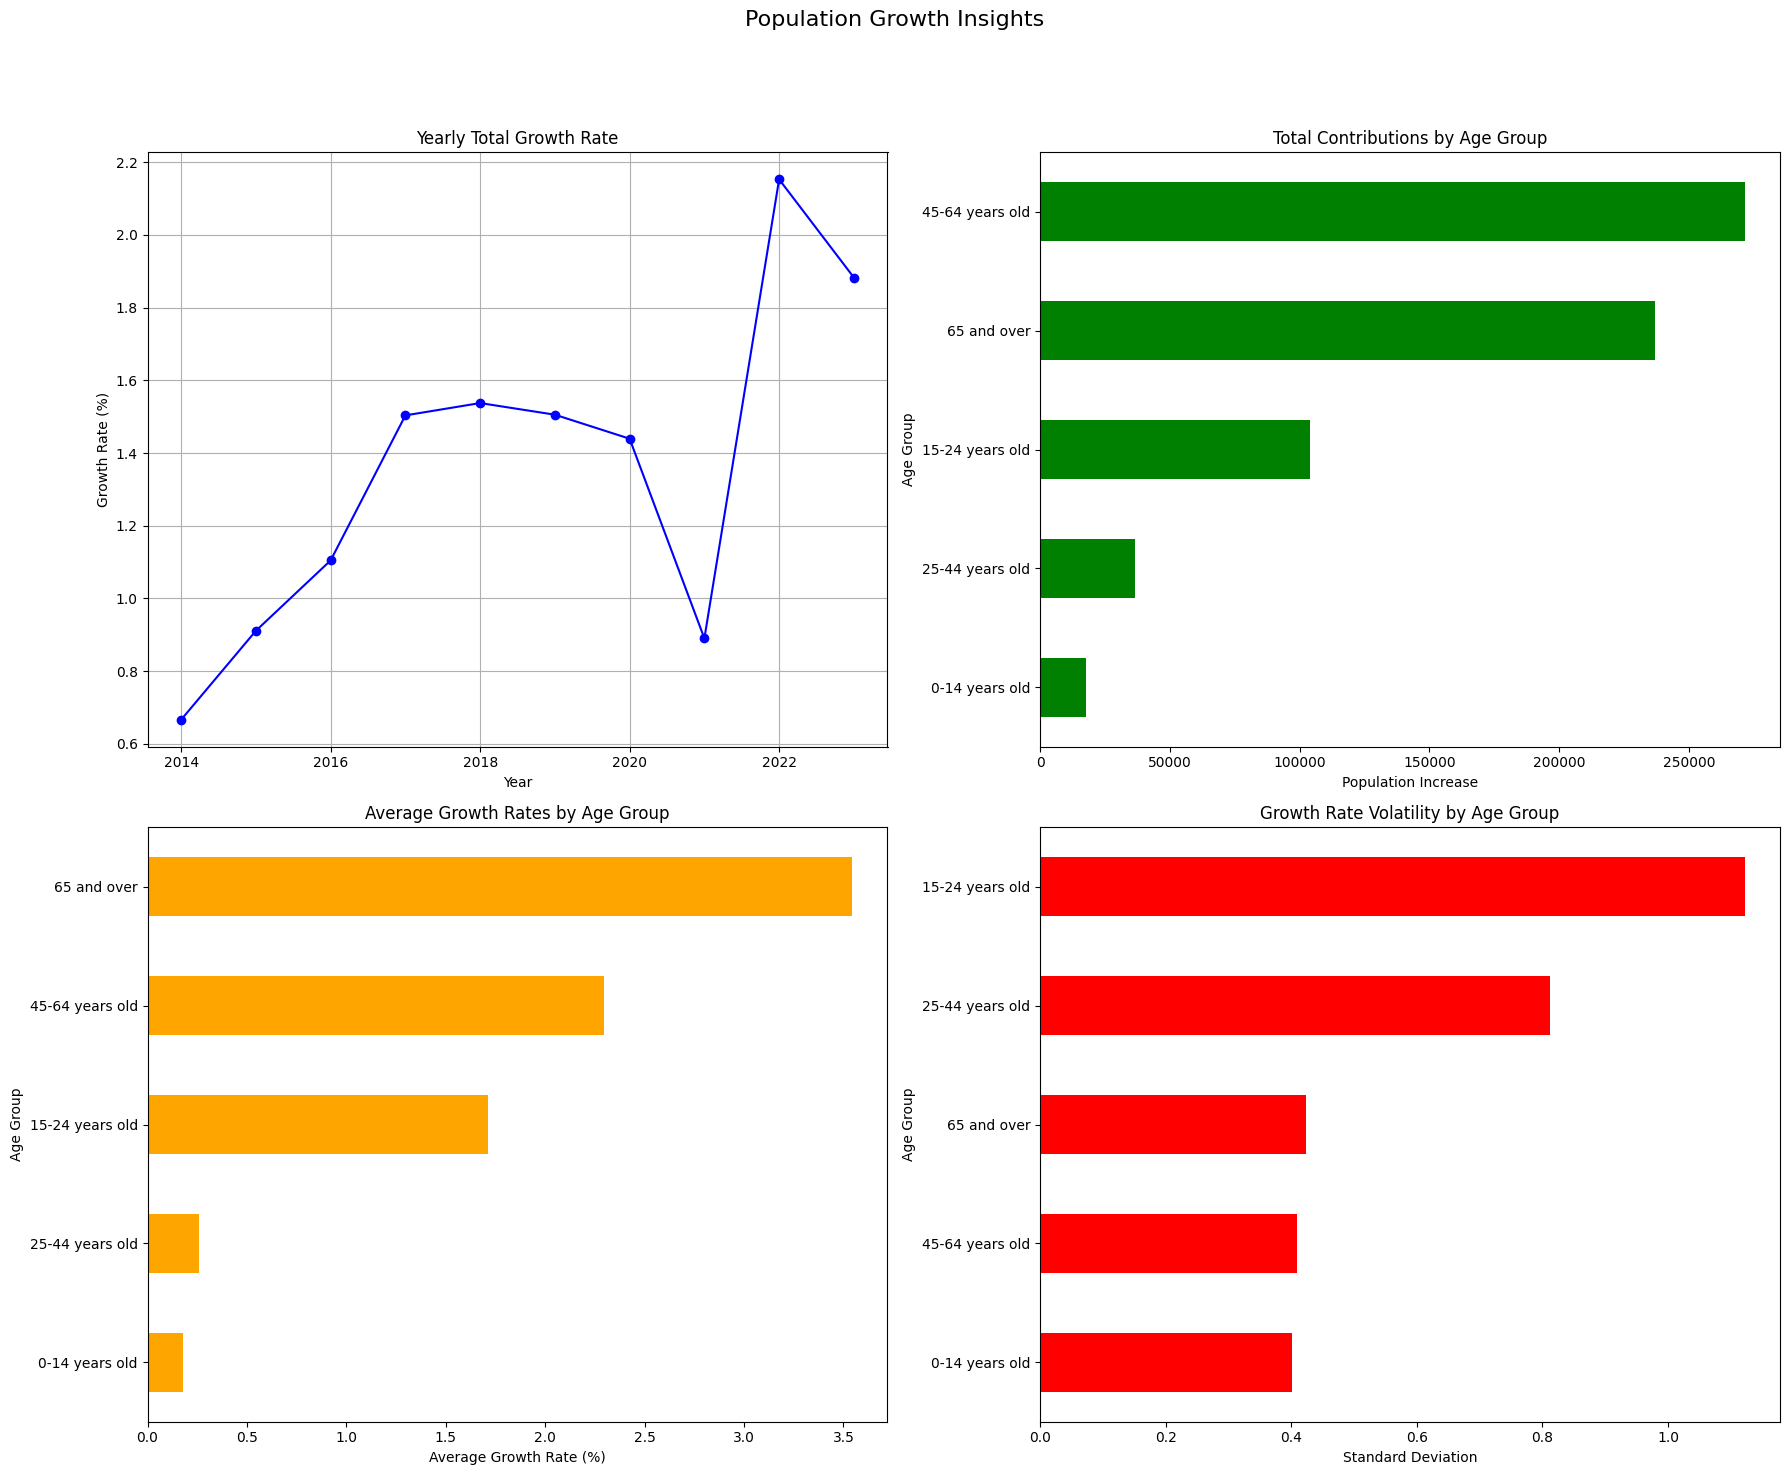

In [336]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
fig.suptitle('Population Growth Insights', fontsize=16, y=1.05)

# Line plot of yearly total growth rate
axes[0, 0].plot(population_pivot_age_groups['Year'], population_pivot_age_groups['Total Growth Rate'], marker='o', color='blue')
axes[0, 0].set_title('Yearly Total Growth Rate')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Growth Rate (%)')
axes[0, 0].grid(True)

# Bar plot of age group contributions
age_group_contributions.sort_values().plot(kind='barh', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Total Contributions by Age Group')
axes[0, 1].set_xlabel('Population Increase')
axes[0, 1].set_ylabel('Age Group')

# Bar plot of average growth rates by age group
age_group_trends.sort_values().plot(kind='barh', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Average Growth Rates by Age Group')
axes[1, 0].set_xlabel('Average Growth Rate (%)')
axes[1, 0].set_ylabel('Age Group')

# Bar plot of growth rate volatility
growth_rate_std.sort_values().plot(kind='barh', ax=axes[1, 1], color='red')
axes[1, 1].set_title('Growth Rate Volatility by Age Group')
axes[1, 1].set_xlabel('Standard Deviation')
axes[1, 1].set_ylabel('Age Group')

plt.tight_layout()
plt.show()

**Yearly Total Growth Analysis:**

The average change in the yearly total growth rate is approximately 
0.135
%
This value indicates the average yearly change in the growth rate. Since it's positive, it suggests that the growth rate has been increasing on average year over year, but the magnitude of the change is relatively small.

Age Group Impact:

The "45-64 years old" age group has contributed the most to the total population growth with an increase of approximately 271,524 people over the years.
The "65 and over" age group follows closely with an increase of approximately 237,110 people.
The "0-14 years old" age group has had the least contribution to growth with only an increase of about 17,730 people.
Age Group Trends:

On average, the "65 and over" age group has the highest growth rate at approximately 
3.54
%

The "15-24 years old" age group follows with an average growth rate of approximately 
1.71
%

The "0-14 years old" age group has the lowest average growth rate at around 
0.18
%



The "15-24 years old" age group has shown the most fluctuation in its growth rate over the years, as indicated by its highest standard deviation.
The "0-14 years old" age group has the least variability in its growth rates, making it the most stable.

In [337]:
immigration_df = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['Year'] >= 2000) & (migration_df_1996['Country'] != 'All countries')]
immigration_df

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
182,2000,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,20.8
191,2000,US,United States,-,Both sexes,5,Immigrants: All origins,Thousand,5.5
200,2000,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,14.5
218,2000,E1420XIE,EU14 excl Irl (UK & Ireland),-,Both sexes,5,Immigrants: All origins,Thousand,11.7
227,2001,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,20.6
...,...,...,...,...,...,...,...,...,...
1667,2023,CA,Canada,-,Both sexes,5,Immigrants: All origins,Thousand,7.2
1676,2023,AU,Australia,-,Both sexes,5,Immigrants: All origins,Thousand,7.7
1685,2023,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,75.8
1703,2023,E1420XIE,EU14 excl Irl (UK & Ireland),-,Both sexes,5,Immigrants: All origins,Thousand,17.7


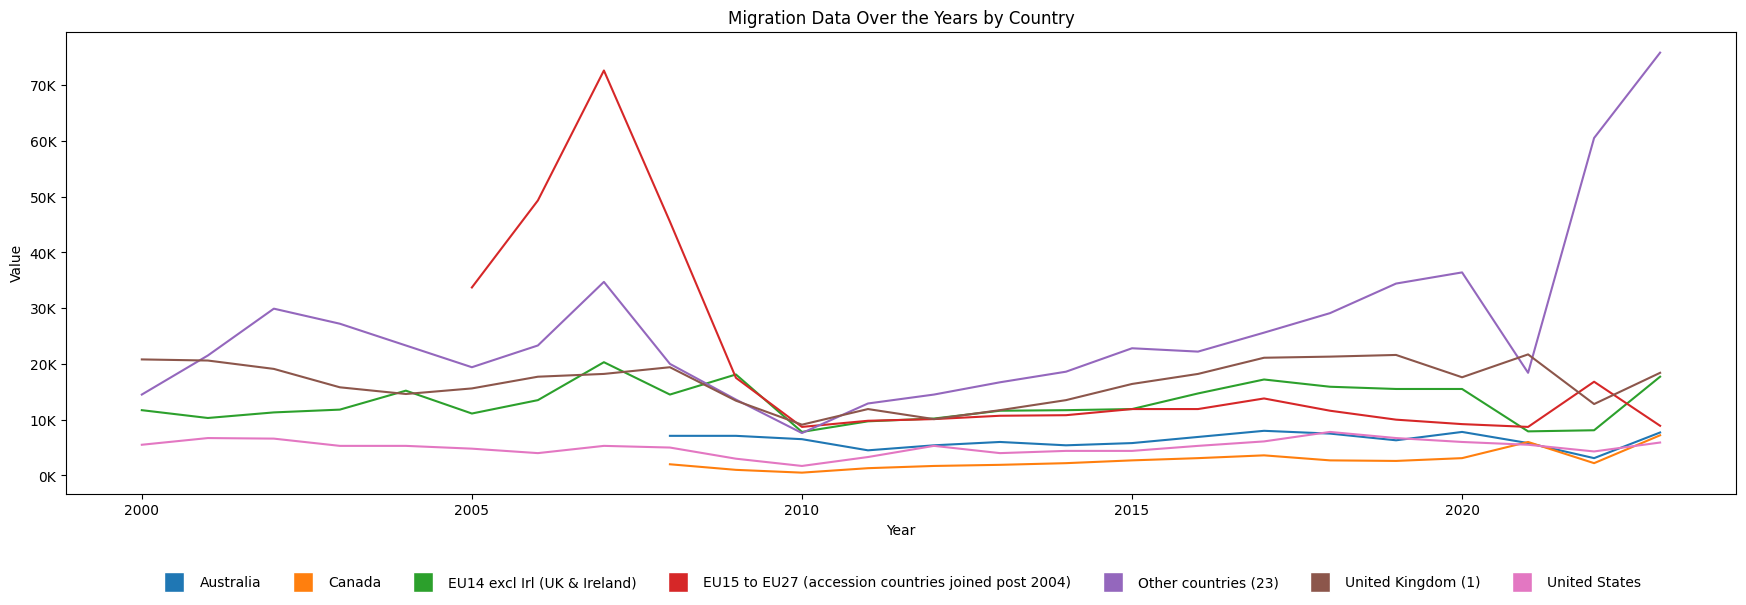

In [338]:
plt.figure(figsize=(21.55, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
legend_elements = []

pivot_table_immigration = immigration_df.pivot_table(index='Year', columns='Country', values='VALUE', aggfunc= 'sum')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Migration Data Over the Years by Country')

for i, country in enumerate(pivot_table_immigration.columns):
    color = colors[i]
    plt.plot(pivot_table_immigration.index, pivot_table_immigration[country], color, label=country)
    #legend_elements.append(Line2D([0], [0], color=color, label=country))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color,label=country, markersize=15))

current_y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(y)}K' for y in current_y_ticks])
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8, frameon=False)
plt.show()

In [339]:
immigration_df_all_countries_total = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['Year'] >= 2015) & (migration_df_1996['Country'] == 'All countries')]
immigration_df_all_countries_total

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
1118,2015,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,75.9
1190,2016,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,82.3
1262,2017,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.3
1334,2018,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,96.0
1406,2019,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,97.1
1478,2020,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.6
1550,2021,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,74.1
1622,2022,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,107.8
1694,2023,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,141.6


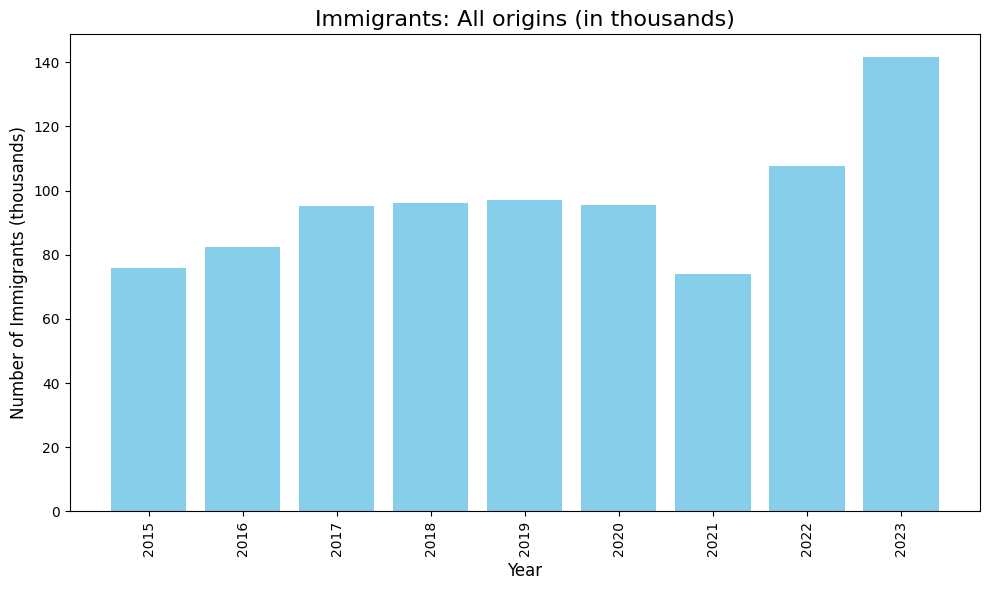

In [340]:

# Data for creating the bar chart
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
values = [75.9, 82.3, 95.3, 96.0, 97.1, 95.6, 74.1, 107.8, 141.6]


plt.figure(figsize=(10, 6))
plt.bar(years, values, color='skyblue')


plt.title('Immigrants: All origins (in thousands)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Immigrants (thousands)', fontsize=12)
plt.xticks(rotation=90) 
plt.tight_layout() 

plt.show()

In [341]:
emigrants_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Emigrants: All destinations') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
immigrants_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
net_migration_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Net migration') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
migration_years_1996 = migration_df_1996['Year'].unique()
emigrants_values_1996 = emigrants_1996['VALUE'].values
immigrants_values_1996 = immigrants_1996['VALUE'].values
net_migration_values_1996 = net_migration_1996['VALUE'].values


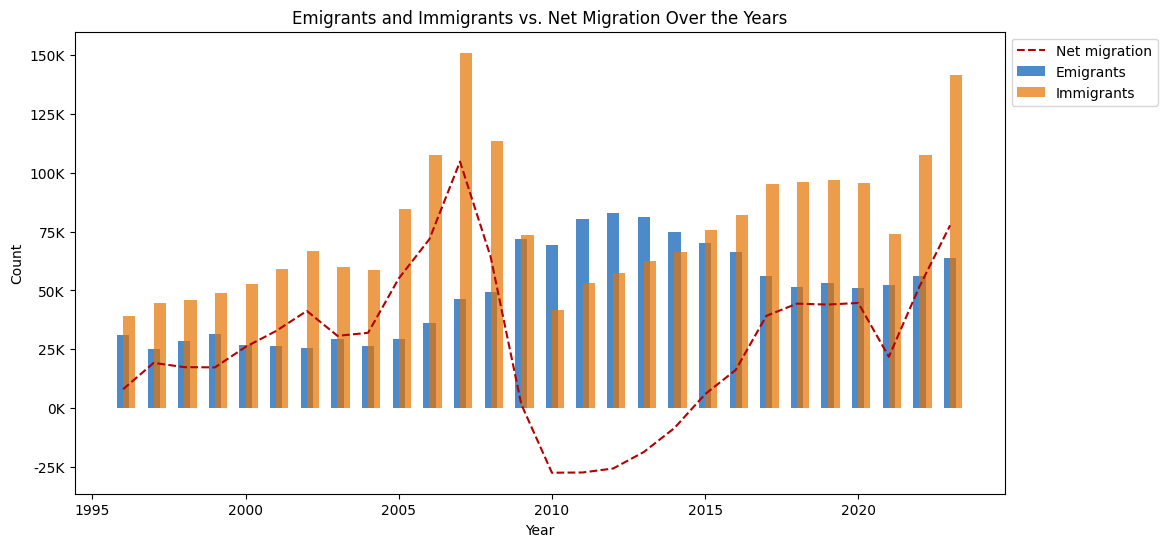

In [342]:
plt.figure(figsize=(12,6))

plt.bar(migration_years_1996, emigrants_values_1996, label='Emigrants', color='#0059b3', alpha=0.7, width=0.4)
plt.bar(migration_years_1996, immigrants_values_1996, label='Immigrants', color='#e67300', alpha=0.7, width=0.4, align='edge')


plt.plot(migration_years_1996, net_migration_values_1996, label='Net migration', marker='', linestyle='--', color='#b30000')

current_y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(y)}K' for y in current_y_ticks])
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.title('Emigrants and Immigrants vs. Net Migration Over the Years')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The immigration dataset used above has only the country breakdown. However, in order to get more data for applying the machine learning, I decided that I will use another dataset for the immigration, which has the age breakdown by age groups. Then, I will create again the column for the Age Groups in the population dataset, in order to make sure that they are matching exaclty the Age Groups from the immigration dataset, so that later on I can perform a join on both datasets and apply the machine learning algorithms.

### Loading the migration dataset with age groups

In [343]:
migration_df_age_group = pd.read_csv('PEA03.20231022T221016.csv')

In [344]:
migration_df_age_group.head(7)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02076V03371,Age Group,C02199V02655,Sex,C02542V03077,Inward or Outward Flow,UNIT,VALUE
0,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,1,Net migration,Thousand,-23.0
1,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,4,Emigrants: All destinations,Thousand,40.2
2,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,5,Immigrants: All origins,Thousand,17.2
3,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,1,Net migration,Thousand,NaN
4,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,4,Emigrants: All destinations,Thousand,NaN
5,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,5,Immigrants: All origins,Thousand,NaN
6,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,1,Net migration,Thousand,NaN


### Data preparation

In [345]:
population_df = population_df_1996.drop(['Age category'], axis=1)

populattion_df_age_groups_for_ml = population_df[(population_df['Single Year of Age'] != 'All ages') & (population_df['Year'] >= 1996) & (population_df['Sex'] != 'Both sexes')]
populattion_df_age_groups_for_ml['Single Year of Age'] = populattion_df_age_groups_for_ml['Single Year of Age'].str.extract(r'(\d+)').astype(int)

populattion_df_age_groups_for_ml.head(7)

,Year,Single Year of Age,Sex category,Sex,UNIT,VALUE
4,1996,1,1,Male,Number,25231
5,1996,1,2,Female,Number,23623
7,1996,1,1,Male,Number,24963
8,1996,1,2,Female,Number,23611
10,1996,2,1,Male,Number,25245
11,1996,2,2,Female,Number,23766
13,1996,3,1,Male,Number,26005


#### Defining the age grouping column

In [346]:
def age_group(age):
    if age <= 14:
        return '0 - 14 years'
    elif age <= 24:
        return '15 - 24 years'
    elif age <= 44:
        return '25 - 44 years'
    elif age <= 64:
        return '45 - 64 years'
    else:
        return '65 years and over'

populattion_df_age_groups_for_ml['Age Group'] = populattion_df_age_groups_for_ml['Single Year of Age'].apply(age_group)

populattion_df_age_groups_for_ml


,Year,Single Year of Age,Sex category,Sex,UNIT,VALUE,Age Group
4,1996,1,1,Male,Number,25231,0 - 14 years
5,1996,1,2,Female,Number,23623,0 - 14 years
7,1996,1,1,Male,Number,24963,0 - 14 years
8,1996,1,2,Female,Number,23611,0 - 14 years
10,1996,2,1,Male,Number,25245,0 - 14 years
...,...,...,...,...,...,...,...
8477,2023,97,2,Female,Number,821,65 years and over
8479,2023,98,1,Male,Number,197,65 years and over
8480,2023,98,2,Female,Number,632,65 years and over
8482,2023,99,1,Male,Number,352,65 years and over


In [347]:
populattion_df_age_groups_for_ml.drop(['Single Year of Age'], axis = 1)

populattion_grouped_by_year = populattion_df_age_groups_for_ml.groupby(['Year', 'Age Group', 'Sex'])['VALUE'].sum().reset_index()

populattion_grouped_by_year

,Year,Age Group,Sex,VALUE
0,1996,0 - 14 years,Female,417972
1,1996,0 - 14 years,Male,441452
2,1996,15 - 24 years,Female,309797
3,1996,15 - 24 years,Male,323093
4,1996,25 - 44 years,Female,512789
...,...,...,...,...
275,2023,25 - 44 years,Male,708172
276,2023,45 - 64 years,Female,677223
277,2023,45 - 64 years,Male,661516
278,2023,65 years and over,Female,426368


Dropping irrelevant columns for the new migration dataset added.

In [348]:
migration_df_age_group = migration_df_age_group.drop(['STATISTIC', 'TLIST(A1)', 'C02076V03371','C02199V02655','C02542V03077'  ], axis=1)

migration_df_age_group_for_ml = migration_df_age_group[(migration_df_age_group['Age Group'] != 'All ages') & (migration_df_age_group['Year'] > 1995) & (migration_df_age_group['Sex'] != 'Both sexes')]

In [349]:
migration_df_age_group_for_ml.head(10)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
498,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,NaN
499,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
500,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
501,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,NaN
502,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
503,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
507,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Net migration,Thousand,NaN
508,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Emigrants: All destinations,Thousand,9.8
509,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Immigrants: All origins,Thousand,4.2
510,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,NaN


In [350]:
migration_df_age_group_for_ml.isna().sum()

STATISTIC Label            0
Year                       0
Age Group                  0
Sex                        0
Inward or Outward Flow     0
UNIT                       0
VALUE                     60
dtype: int64

We have some missing values for the net migration only as it can be seen above. However, the net migration is the difference between immigrants and emigrants, so this can be easily calculated and those values can be imputated (in comparison with the null values in the first migration dataset we used - there the way to go was to drop those empty values because we did not have the data for the immigrants, emigrants and respectfully for net migration, hence imputation was going to result in bias data).

In [351]:
def calculate_net_migration(group):
    immigrants = group[group['Inward or Outward Flow'] == 'Immigrants: All origins']['VALUE'].values[0]
    emigrants = group[group['Inward or Outward Flow'] == 'Emigrants: All destinations']['VALUE'].values[0]
    net_migration = immigrants - emigrants
    group.loc[group['Inward or Outward Flow'] == 'Net migration', 'VALUE'] = net_migration
    return group

# Apply the function to each group
migration_df_age_group_for_ml = migration_df_age_group_for_ml.groupby(['Year', 'Age Group', 'Sex']).apply(calculate_net_migration).reset_index(drop=True)

# Display the updated dataframe to verify the imputation
migration_df_age_group_for_ml.head(7)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2.7
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
5,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
6,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,-5.0


Converting the unit of the VALUE so that it can match the VALUE unit from the population

In [352]:
migration_df_age_group_for_ml['VALUE'] = migration_df_age_group_for_ml['VALUE'] * 1000

In [353]:
migration_df_age_group_for_ml.head(7)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3000.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,600.0
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3600.0
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2700.0
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,400.0
5,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3100.0
6,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,-5000.0


#### Merging already aligned datasets with right merge

In [354]:
merged_df = pd.merge(populattion_grouped_by_year, migration_df_age_group_for_ml, on=['Year', 'Age Group', 'Sex'], how='right') 
#using a right join, meaning that we are keeping all rows from the migration dataset (so that we can get the breakdown for 'Inward or Outward Flow')

df_merged_final = merged_df.drop('UNIT', axis=1)

In [355]:
df_merged_final.head(10)

,Year,Age Group,Sex,VALUE_x,STATISTIC Label,Inward or Outward Flow,VALUE_y
0,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Net migration,3000.0
1,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Emigrants: All destinations,600.0
2,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Immigrants: All origins,3600.0
3,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Net migration,2700.0
4,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Emigrants: All destinations,400.0
5,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Immigrants: All origins,3100.0
6,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Net migration,-5000.0
7,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Emigrants: All destinations,11700.0
8,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Immigrants: All origins,6700.0
9,1996,15 - 24 years,Male,323093,Estimated Migration (Persons in April),Net migration,-5600.0


We do have some duplicated values for the VALUE_x column (which is the population) because for each row of data for the population dataset we have three rows from the migration dataset because of the Inward or Outward Flow breakdown. Because of that I am creating a pivot table to avoid any errors.

In [356]:
pivot_df = df_merged_final.pivot_table(
    index=['Year', 'Age Group', 'Sex', 'VALUE_x'], 
    columns='Inward or Outward Flow', 
    values='VALUE_y', 
    aggfunc='first'  # Since we assume there is only one value for each type and group
).reset_index()

pivot_df.head()

Inward or Outward Flow,Year,Age Group,Sex,VALUE_x,Emigrants: All destinations,Immigrants: All origins,Net migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


Rename the merged columns for clarity

In [357]:
# Rename the columns for clarity
pivot_df.columns.name = None  # Remove the name of the columns' level
pivot_df = pivot_df.rename(columns={
    "Emigrants: All destinations": "Emigrants_All_Destinations",
    "Immigrants: All origins": "Immigrants_All_Origins",
    "Net migration": "Net_Migration",
    "VALUE_x": 'Population'
})

pivot_df.head()

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


In [358]:
pivot_df['Migration_Rate'] = (pivot_df['Net_Migration'] / pivot_df['Population']) * 1000

# Changin dataframe name for readability
population_migration_df = pivot_df

population_migration_df.head(7)

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0,7.177514
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0,6.116180
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0,-16.139601
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0,-17.332471
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0,9.945611
5,1996,25 - 44 years,Male,503302,5100.0,8700.0,3600.0,7.152763
6,1996,45 - 64 years,Female,348667,700.0,1300.0,600.0,1.720840


I will use the Shapiro-Wilk test to determine if the migration rate data for various age groups are consistent with a normal distribution. 

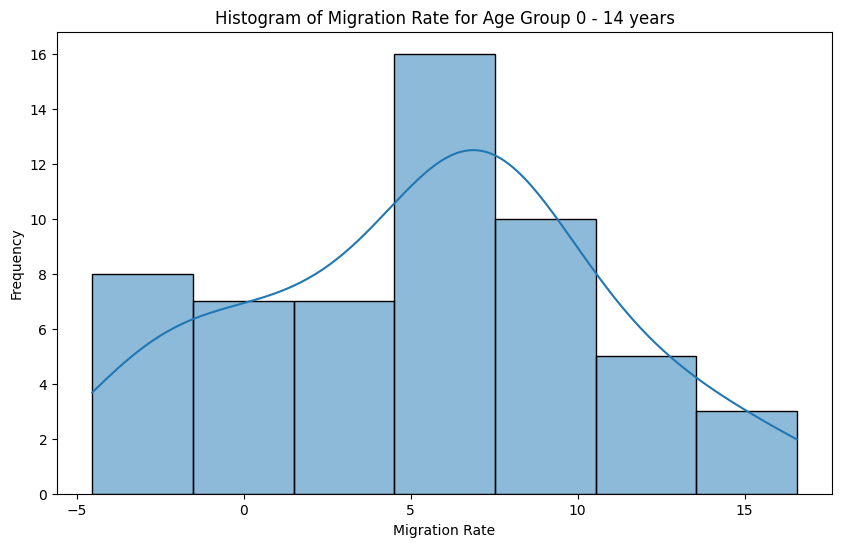

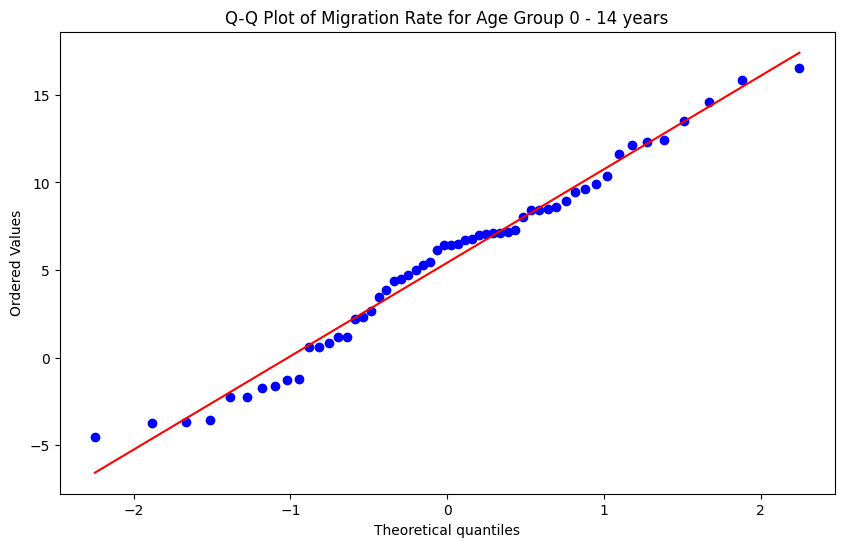

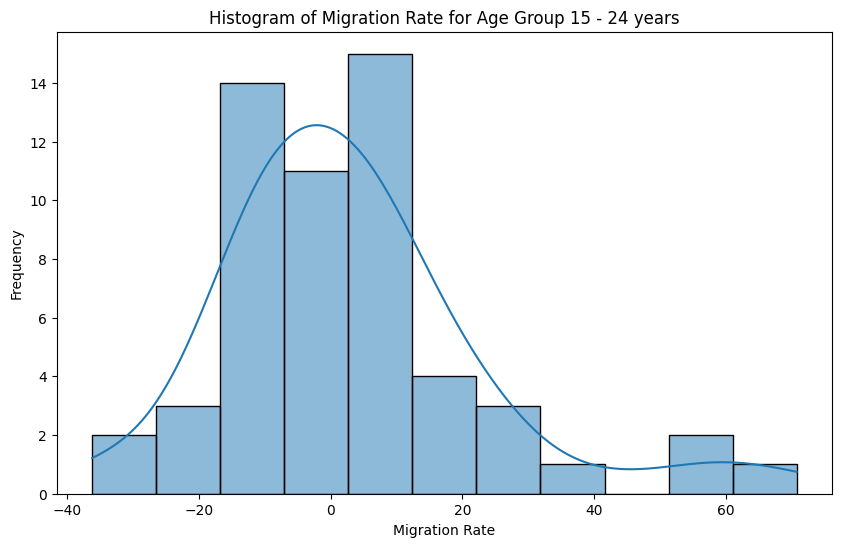

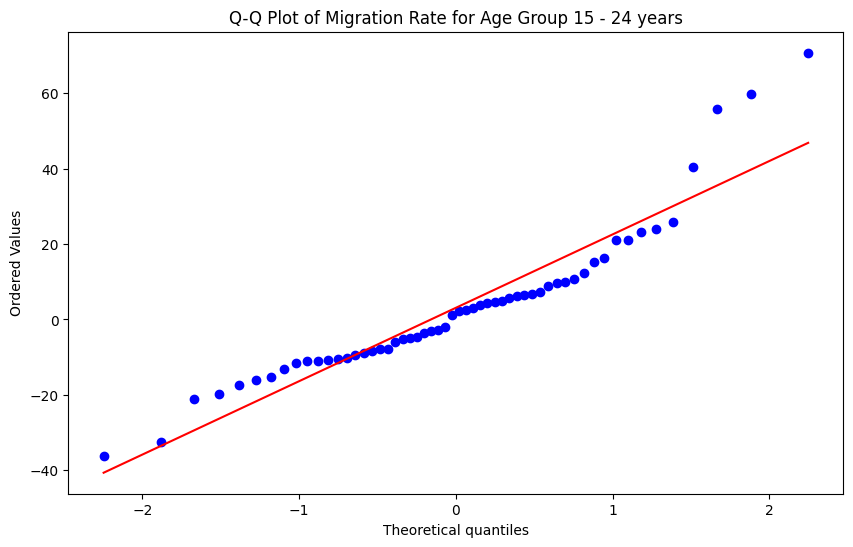

{'0 - 14 years': ShapiroResult(statistic=0.9760842323303223, pvalue=0.3281641900539398),
 '15 - 24 years': ShapiroResult(statistic=0.9030325412750244, pvalue=0.00028005740023218095)}

In [359]:
# Get unique age groups from the dataset
selected_age_groups = ['0 - 14 years', '15 - 24 years']

# Create a dictionary to store the results of Shapiro-Wilk test for each age group
shapiro_results = {}

# Plotting histograms and Q-Q plots for each age group and performing Shapiro-Wilk test
for age_group in selected_age_groups:
    # Filter the dataset for the current age group
    current_age_group_data = population_migration_df[population_migration_df['Age Group'] == age_group]

    # Visual assessment of normality using a histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(current_age_group_data['Migration_Rate'], kde=True)
    plt.title(f'Histogram of Migration Rate for Age Group {age_group}')
    plt.xlabel('Migration Rate')
    plt.ylabel('Frequency')
    plt.show()

    # Visual assessment of normality using a Q-Q plot
    plt.figure(figsize=(10, 6))
    stats.probplot(current_age_group_data['Migration_Rate'], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Migration Rate for Age Group {age_group}')
    plt.show()

    # Perform the Shapiro-Wilk test for normality
    shapiro_test = stats.shapiro(current_age_group_data['Migration_Rate'])
    shapiro_results[age_group] = shapiro_test

shapiro_results


Age Group 0 - 14 years

The histogram likely showed a bell-shaped curve, which is one indicator of normal distribution.

If the points in the Q-Q plot followed a straight line closely, this would be another indicator that the data comes from a distribution that is approximately normal. Deviations at the ends of the plot can indicate skewness or the presence of outliers.

Shapiro-Wilk Test: With a p-value of approximately 0.328, the test does not provide enough evidence to reject the null hypothesis that the data is normally distributed. This means that, statistically, the migration rate for the 0 - 14 years age group can be considered to follow a normal distribution at the 5% significance level (α=0.05)

Age Group 15 - 24 years

The p-value is less that the α, meaning that the null hypothesis can be rejected, which indicates that the data does not follow the normal distribution. 

For the purpose of the exercise, I am assuming that the migration rate for the age group 0 - 14 years follows a normal distribution based on the Shapiro-Wilk test, which did not provide sufficient evidence to reject the null hypothesis at the 5% significance level. Given this assumption, I will proceed to calculate probabilities regarding the migration rate for this age group.

In [360]:
age_group_0_14_data = population_migration_df[population_migration_df['Age Group'] == '0 - 14 years']


In [361]:
mu = age_group_0_14_data['Migration_Rate'].mean()
sigma = age_group_0_14_data['Migration_Rate'].std()

mu, sigma

(5.414663764591353, 5.2542681950880565)

In [362]:
prob_below_2 = stats.norm.cdf(2, mu, sigma)

# Calculate the probability that the migration rate is greater than 8% for the 0-14 age group
prob_above_8 = 1 - stats.norm.cdf(8, mu, sigma)

prob_below_2, prob_above_8

(0.2578836426103457, 0.3113437766894116)

The probability that the migration rate will be less than 2% is approximately 25.79%.
The probability that the migration rate will be greater than 8% is approximately 31.13%